# Saving and Restoring Models with Callbacks

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt

## Get the data

In [2]:
housing = fetch_california_housing()

### Create train, validation and test sets

In [3]:
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [5]:
X_train.shape

(11610, 8)

In [6]:
X_test.shape

(5160, 8)

In [7]:
X_valid.shape

(3870, 8)

### Scale the data

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

In [9]:
X_train.shape[1:]

(8,)

### Split the data further into different subsets

In [10]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]

In [11]:
X_train_A.shape

(11610, 5)

In [12]:
X_train_B.shape

(11610, 6)

## Create the model

We create a model with two input layers. In our scenario, we only feed different subsets of features into the two input layers. Input layer A is directly connected to a concatenate layer (the *wide* part), while input layer B is fed into two subsequent hidden layers 1 and 2 (the *deep* part), with the latter connecting to the concatenate layer as well. From the concatenate layer, the main output is generated. As an additional output, the auxiliary output layer is generated from hidden layer 2.<br>
The auxiliary output layer can be used to make sure that the deep part of the network trains some useful features on its own, without relying on the wide part.

In [13]:
input_A = keras.layers.Input(shape=X_train_A.shape[1:], name='wide_input')
input_B = keras.layers.Input(shape=X_train_B.shape[1:], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu', name='hidden_1')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu', name='hidden_2')(hidden1)
concat = keras.layers.Concatenate(name='wide_concat')([input_A, hidden2])
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

In [14]:
model.compile(
    loss=['mse', 'mse'],
    loss_weights=[0.9, 0.1],
    optimizer=keras.optimizers.SGD(lr=5e-3),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mean_absolute_percentage_error']
)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
hidden_2 (Dense)                (None, 30)           930         hidden_1[0][0]                   
______________________________________________________________________________________________

## Specify the model callbacks

We only store the model with the best parameters and implement early stopping.

In [16]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('chapter10_housing_model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

We additionally define a custom callback which prints the validation loss over the training loss at the end of each epoch in order to detect overfitting:

In [17]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print('\nval/train: {:.2f}'.format(logs['val_loss']/logs['loss']))

## Train the model

In [18]:
history = model.fit(
    {'wide_input': X_train_A, 'deep_input': X_train_B},
    {'main_output': y_train, 'aux_output': y_train},
    epochs=150,
    validation_data=(
        {'wide_input': X_valid_A, 'deep_input': X_valid_B},
        {'main_output': y_valid, 'aux_output': y_valid}
    ),
    callbacks=[checkpoint_cb, early_stopping_cb, PrintValTrainRatioCallback()]
)

Epoch 1/150
363/363 [==============================] - 2s 3ms/step - loss: 1.7413 - main_output_loss: 1.4978 - aux_output_loss: 3.9322 - main_output_root_mean_squared_error: 1.2044 - main_output_mean_absolute_percentage_error: 46.6741 - aux_output_root_mean_squared_error: 1.9732 - aux_output_mean_absolute_percentage_error: 75.0144 - val_loss: 0.7058 - val_main_output_loss: 0.6103 - val_aux_output_loss: 1.5657 - val_main_output_root_mean_squared_error: 0.7812 - val_main_output_mean_absolute_percentage_error: 33.9615 - val_aux_output_root_mean_squared_error: 1.2513 - val_aux_output_mean_absolute_percentage_error: 47.2907

val/train: 0.58
Epoch 2/150
363/363 [==============================] - 0s 751us/step - loss: 0.6846 - main_output_loss: 0.5986 - aux_output_loss: 1.4595 - main_output_root_mean_squared_error: 0.7736 - main_output_mean_absolute_percentage_error: 33.9323 - aux_output_root_mean_squared_error: 1.2079 - aux_output_mean_absolute_percentage_error: 49.1170 - val_loss: 0.5979 - 


val/train: 0.94
Epoch 14/150
363/363 [==============================] - 0s 708us/step - loss: 0.4377 - main_output_loss: 0.4104 - aux_output_loss: 0.6833 - main_output_root_mean_squared_error: 0.6404 - main_output_mean_absolute_percentage_error: 27.1257 - aux_output_root_mean_squared_error: 0.8264 - aux_output_mean_absolute_percentage_error: 37.1618 - val_loss: 0.4299 - val_main_output_loss: 0.4030 - val_aux_output_loss: 0.6719 - val_main_output_root_mean_squared_error: 0.6348 - val_main_output_mean_absolute_percentage_error: 24.9081 - val_aux_output_root_mean_squared_error: 0.8197 - val_aux_output_mean_absolute_percentage_error: 34.9602

val/train: 0.95
Epoch 15/150
363/363 [==============================] - 0s 744us/step - loss: 0.4467 - main_output_loss: 0.4191 - aux_output_loss: 0.6955 - main_output_root_mean_squared_error: 0.6468 - main_output_mean_absolute_percentage_error: 27.0945 - aux_output_root_mean_squared_error: 0.8338 - aux_output_mean_absolute_percentage_error: 36.6786 


val/train: 0.93
Epoch 27/150
363/363 [==============================] - 0s 706us/step - loss: 0.3904 - main_output_loss: 0.3711 - aux_output_loss: 0.5639 - main_output_root_mean_squared_error: 0.6091 - main_output_mean_absolute_percentage_error: 24.9715 - aux_output_root_mean_squared_error: 0.7509 - aux_output_mean_absolute_percentage_error: 32.4232 - val_loss: 0.3761 - val_main_output_loss: 0.3568 - val_aux_output_loss: 0.5501 - val_main_output_root_mean_squared_error: 0.5973 - val_main_output_mean_absolute_percentage_error: 24.8922 - val_aux_output_root_mean_squared_error: 0.7417 - val_aux_output_mean_absolute_percentage_error: 32.2051

val/train: 0.93
Epoch 28/150
363/363 [==============================] - 0s 745us/step - loss: 0.3981 - main_output_loss: 0.3789 - aux_output_loss: 0.5712 - main_output_root_mean_squared_error: 0.6153 - main_output_mean_absolute_percentage_error: 25.4839 - aux_output_root_mean_squared_error: 0.7556 - aux_output_mean_absolute_percentage_error: 32.2964 


val/train: 0.94
Epoch 40/150
363/363 [==============================] - 0s 715us/step - loss: 0.3697 - main_output_loss: 0.3528 - aux_output_loss: 0.5214 - main_output_root_mean_squared_error: 0.5939 - main_output_mean_absolute_percentage_error: 23.9494 - aux_output_root_mean_squared_error: 0.7220 - aux_output_mean_absolute_percentage_error: 31.0406 - val_loss: 0.3507 - val_main_output_loss: 0.3355 - val_aux_output_loss: 0.4877 - val_main_output_root_mean_squared_error: 0.5792 - val_main_output_mean_absolute_percentage_error: 21.6245 - val_aux_output_root_mean_squared_error: 0.6984 - val_aux_output_mean_absolute_percentage_error: 29.1111

val/train: 0.95
Epoch 41/150
363/363 [==============================] - 0s 739us/step - loss: 0.3577 - main_output_loss: 0.3413 - aux_output_loss: 0.5056 - main_output_root_mean_squared_error: 0.5840 - main_output_mean_absolute_percentage_error: 23.7181 - aux_output_root_mean_squared_error: 0.7109 - aux_output_mean_absolute_percentage_error: 29.9424 


val/train: 0.94
Epoch 53/150
363/363 [==============================] - 0s 746us/step - loss: 0.3323 - main_output_loss: 0.3180 - aux_output_loss: 0.4618 - main_output_root_mean_squared_error: 0.5637 - main_output_mean_absolute_percentage_error: 22.1261 - aux_output_root_mean_squared_error: 0.6794 - aux_output_mean_absolute_percentage_error: 28.9267 - val_loss: 0.3268 - val_main_output_loss: 0.3134 - val_aux_output_loss: 0.4477 - val_main_output_root_mean_squared_error: 0.5598 - val_main_output_mean_absolute_percentage_error: 22.1227 - val_aux_output_root_mean_squared_error: 0.6691 - val_aux_output_mean_absolute_percentage_error: 29.2743

val/train: 0.94
Epoch 54/150
363/363 [==============================] - 0s 715us/step - loss: 0.3450 - main_output_loss: 0.3304 - aux_output_loss: 0.4769 - main_output_root_mean_squared_error: 0.5747 - main_output_mean_absolute_percentage_error: 23.0087 - aux_output_root_mean_squared_error: 0.6905 - aux_output_mean_absolute_percentage_error: 30.0556 


val/train: 0.95
Epoch 66/150
363/363 [==============================] - 0s 758us/step - loss: 0.3288 - main_output_loss: 0.3160 - aux_output_loss: 0.4439 - main_output_root_mean_squared_error: 0.5620 - main_output_mean_absolute_percentage_error: 21.9191 - aux_output_root_mean_squared_error: 0.6662 - aux_output_mean_absolute_percentage_error: 28.2536 - val_loss: 0.3162 - val_main_output_loss: 0.3047 - val_aux_output_loss: 0.4195 - val_main_output_root_mean_squared_error: 0.5520 - val_main_output_mean_absolute_percentage_error: 20.7766 - val_aux_output_root_mean_squared_error: 0.6477 - val_aux_output_mean_absolute_percentage_error: 27.3797

val/train: 0.94
Epoch 67/150
363/363 [==============================] - 0s 742us/step - loss: 0.3283 - main_output_loss: 0.3172 - aux_output_loss: 0.4285 - main_output_root_mean_squared_error: 0.5631 - main_output_mean_absolute_percentage_error: 21.5747 - aux_output_root_mean_squared_error: 0.6545 - aux_output_mean_absolute_percentage_error: 27.8056 


val/train: 0.94
Epoch 79/150
363/363 [==============================] - 0s 756us/step - loss: 0.3349 - main_output_loss: 0.3244 - aux_output_loss: 0.4291 - main_output_root_mean_squared_error: 0.5694 - main_output_mean_absolute_percentage_error: 21.9658 - aux_output_root_mean_squared_error: 0.6550 - aux_output_mean_absolute_percentage_error: 27.6358 - val_loss: 0.3105 - val_main_output_loss: 0.3001 - val_aux_output_loss: 0.4034 - val_main_output_root_mean_squared_error: 0.5478 - val_main_output_mean_absolute_percentage_error: 21.7922 - val_aux_output_root_mean_squared_error: 0.6352 - val_aux_output_mean_absolute_percentage_error: 28.2684

val/train: 0.95
Epoch 80/150
363/363 [==============================] - 0s 728us/step - loss: 0.3283 - main_output_loss: 0.3177 - aux_output_loss: 0.4234 - main_output_root_mean_squared_error: 0.5636 - main_output_mean_absolute_percentage_error: 22.0654 - aux_output_root_mean_squared_error: 0.6506 - aux_output_mean_absolute_percentage_error: 28.0269 


val/train: 0.94
Epoch 92/150
363/363 [==============================] - 0s 761us/step - loss: 0.3088 - main_output_loss: 0.2990 - aux_output_loss: 0.3976 - main_output_root_mean_squared_error: 0.5465 - main_output_mean_absolute_percentage_error: 21.5852 - aux_output_root_mean_squared_error: 0.6303 - aux_output_mean_absolute_percentage_error: 26.9056 - val_loss: 0.3054 - val_main_output_loss: 0.2964 - val_aux_output_loss: 0.3860 - val_main_output_root_mean_squared_error: 0.5444 - val_main_output_mean_absolute_percentage_error: 20.8402 - val_aux_output_root_mean_squared_error: 0.6213 - val_aux_output_mean_absolute_percentage_error: 26.2751

val/train: 0.95
Epoch 93/150
363/363 [==============================] - 0s 746us/step - loss: 0.3155 - main_output_loss: 0.3046 - aux_output_loss: 0.4138 - main_output_root_mean_squared_error: 0.5518 - main_output_mean_absolute_percentage_error: 21.5623 - aux_output_root_mean_squared_error: 0.6430 - aux_output_mean_absolute_percentage_error: 26.8897 


val/train: 0.98
Epoch 105/150
363/363 [==============================] - 0s 749us/step - loss: 0.3217 - main_output_loss: 0.3119 - aux_output_loss: 0.4098 - main_output_root_mean_squared_error: 0.5584 - main_output_mean_absolute_percentage_error: 21.4537 - aux_output_root_mean_squared_error: 0.6399 - aux_output_mean_absolute_percentage_error: 26.3429 - val_loss: 0.3006 - val_main_output_loss: 0.2919 - val_aux_output_loss: 0.3786 - val_main_output_root_mean_squared_error: 0.5403 - val_main_output_mean_absolute_percentage_error: 20.2496 - val_aux_output_root_mean_squared_error: 0.6153 - val_aux_output_mean_absolute_percentage_error: 25.4600

val/train: 0.94
Epoch 106/150
363/363 [==============================] - 0s 757us/step - loss: 0.3032 - main_output_loss: 0.2941 - aux_output_loss: 0.3857 - main_output_root_mean_squared_error: 0.5422 - main_output_mean_absolute_percentage_error: 21.1125 - aux_output_root_mean_squared_error: 0.6208 - aux_output_mean_absolute_percentage_error: 25.816


val/train: 0.95
Epoch 118/150
363/363 [==============================] - 0s 758us/step - loss: 0.3107 - main_output_loss: 0.3012 - aux_output_loss: 0.3958 - main_output_root_mean_squared_error: 0.5487 - main_output_mean_absolute_percentage_error: 21.3401 - aux_output_root_mean_squared_error: 0.6290 - aux_output_mean_absolute_percentage_error: 26.2282 - val_loss: 0.3008 - val_main_output_loss: 0.2924 - val_aux_output_loss: 0.3772 - val_main_output_root_mean_squared_error: 0.5407 - val_main_output_mean_absolute_percentage_error: 20.3394 - val_aux_output_root_mean_squared_error: 0.6142 - val_aux_output_mean_absolute_percentage_error: 25.4807

val/train: 0.96
Epoch 119/150
363/363 [==============================] - 0s 741us/step - loss: 0.3162 - main_output_loss: 0.3070 - aux_output_loss: 0.3983 - main_output_root_mean_squared_error: 0.5540 - main_output_mean_absolute_percentage_error: 21.4382 - aux_output_root_mean_squared_error: 0.6309 - aux_output_mean_absolute_percentage_error: 26.282

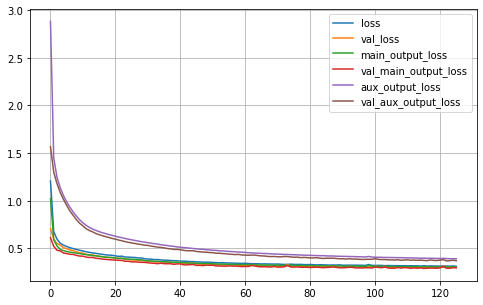

In [19]:
pd.DataFrame(history.history)[['loss', 'val_loss', 'main_output_loss', 'val_main_output_loss', 'aux_output_loss', 'val_aux_output_loss']].plot(figsize=(8,5))
plt.grid(True)
plt.show()

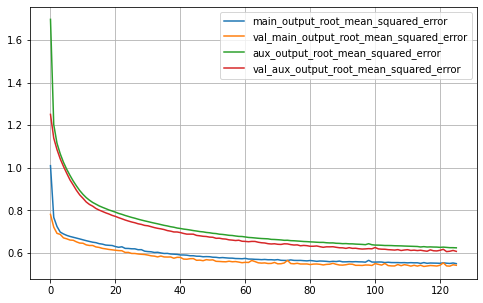

In [20]:
pd.DataFrame(history.history)[['main_output_root_mean_squared_error', 'val_main_output_root_mean_squared_error', 'aux_output_root_mean_squared_error', 'val_aux_output_root_mean_squared_error']].plot(figsize=(8,5))
plt.grid(True)
plt.show()

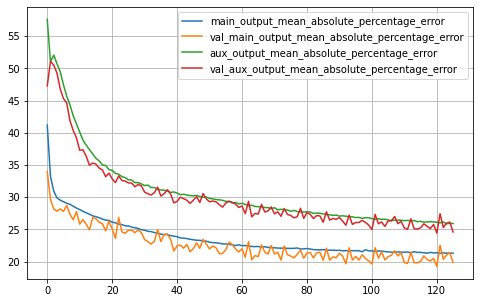

In [21]:
pd.DataFrame(history.history)[['main_output_mean_absolute_percentage_error', 'val_main_output_mean_absolute_percentage_error', 'aux_output_mean_absolute_percentage_error', 'val_aux_output_mean_absolute_percentage_error']].plot(figsize=(8,5))
plt.grid(True)
plt.show()

## Evaluate the model

In [22]:
mse_test = model.evaluate(
    {'wide_input': X_test_A, 'deep_input': X_test_B},
    {'main_output': y_test, 'aux_output': y_test}
)

162/162 [==============================] - 0s 493us/step - loss: 0.3360 - main_output_loss: 0.3268 - aux_output_loss: 0.4188 - main_output_root_mean_squared_error: 0.5717 - main_output_mean_absolute_percentage_error: 21.3263 - aux_output_root_mean_squared_error: 0.6471 - aux_output_mean_absolute_percentage_error: 26.1992


## Manually saving the model

In [23]:
model.save('chapter10_housing_model.h5')

## Manually restoring a model

In [24]:
model2 = keras.models.load_model('chapter10_housing_model.h5')

In [25]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
hidden_2 (Dense)                (None, 30)           930         hidden_1[0][0]                   
______________________________________________________________________________________________

In [26]:
model2.weights

[<tf.Variable 'hidden_1/kernel:0' shape=(6, 30) dtype=float32, numpy=
 array([[-1.46193773e-01, -5.40097356e-02, -8.32018256e-02,
         -2.72700876e-01,  6.38498226e-03, -5.90458393e-01,
          1.88336164e-01,  5.49447797e-02, -9.13036522e-03,
          3.28707576e-01, -2.39122659e-02, -1.36405043e-02,
          4.51832741e-01, -3.40214491e-01,  3.19571234e-02,
          3.29012126e-01,  9.53570455e-02,  4.14885171e-02,
         -1.53308615e-01, -1.30711440e-02, -3.00949067e-02,
          6.97523475e-01, -4.37690824e-01, -1.03490271e-01,
         -2.11297005e-01, -2.56371260e-01, -2.46034697e-01,
         -1.30641177e-01,  2.41848931e-01,  2.03375980e-01],
        [-3.52926970e-01,  2.19696879e-01,  3.91865857e-02,
          2.14496017e-01, -1.73196122e-01,  1.54727668e-01,
          9.92696211e-02,  3.45978677e-01,  8.18507820e-02,
          1.60059184e-01,  2.72846743e-02,  5.65865375e-02,
         -5.61293304e-01, -1.47594409e-02,  3.35525051e-02,
         -3.22600424e-01, -5.

In [27]:
mse_test = model2.evaluate(
    {'wide_input': X_test_A, 'deep_input': X_test_B},
    {'main_output': y_test, 'aux_output': y_test}
)

162/162 [==============================] - 0s 561us/step - loss: 0.3360 - main_output_loss: 0.3268 - aux_output_loss: 0.4188 - main_output_main_output_root_mean_squared_error: 0.5717 - main_output_main_output_mean_absolute_percentage_error: 21.3263 - aux_output_aux_output_root_mean_squared_error: 0.6471 - aux_output_aux_output_mean_absolute_percentage_error: 26.1992
